In [1]:
import gymnasium as gym
import numpy as np
import random
import tensorflow as tf
tf.get_logger().setLevel('INFO')

2023-04-17 09:22:33.129423: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 09:22:33.563002: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def preprocess(frame: np.array):
    """
    Preprocessing
    - extract luminosity 0.299*R + 0.587*G + 0.114*B
    - reshape to 84x84
    """
    def getLuminosity(r, g, b):
        return 0.299 * r + 0.587 * g + 0.114 * b

    # reshape
    reshaped_frame = tf.image.resize(frame, [84, 84]).numpy()

    preprocessed_frame = list()
    
    for x in reshaped_frame:
        x_list = list()
        for y in x:
            x_list.append(getLuminosity(y[0], y[1], y[2]))
        
        preprocessed_frame.append(x_list)

    return np.array(preprocessed_frame).reshape(84, 84, 1)

In [3]:
def create_model(input_shape, output_classes):
    """
    - Network
        - input: 84x84x4
        - conv1: 32 filters of 8x8 with stride 4 rectifier nonlinearly
        - conv2: 64 filters of 4x4 with stride 2 rectifier nonlinearly
        - conv3: 64 filters of 3x3 with stride 1 rectifier
        - dense 512 rectifier units
        - output: action space
    """

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (8,8), strides=4, activation='relu', input_shape=input_shape),
        tf.keras.layers.Conv2D(64, (4,4), strides=2, activation='relu'),
        tf.keras.layers.Conv2D(64, (3,3), strides=1, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(output_classes)
    ])

    return model

In [5]:
import time

In [30]:
def train(environment: gym.Env,
          q1_network: tf.keras.models.Sequential, 
          q2_network: tf.keras.models.Sequential,
          network_update_frequency = 10000,
          minibatch_size = 32,
          min_exploration = 0.1,
          max_exploration = 1,
          exploration_frame = 1000000,
          total_frames=1000000,
          replay_memory_size = 1000000,
          no_op_max = 30,
          gamma_discount_factor = 0.99,
         learning_rate = 0.00025,
         discount_factor = 0.99,
         momentum = 0.95):
    
    exploratory_decay_rate = (max_exploration - min_exploration)/exploration_frame
    
    loss_fn = tf.keras.losses.Huber()
    optimizer=tf.keras.optimizers.RMSprop(
        learning_rate=learning_rate,
        rho=discount_factor,
        momentum=gradient_momentum)
    
    episode_scores = list()
    frame_diff = list()
    
    frame_number = 0
    episode = 0
    
    while frame_number <= total_frames:
        state, info = environment.reset()
        frame_number = info['frame_number']
        proc_state = preprocess(state)
        terminated, truncated = False, False

        replay_memory = list()
        n_op = 0

        # logging
        ep_reward = 0
        losses = list()

        while not terminated and not truncated:
            #print(f"Frame {info['frame_number']}")
            #start = time.time()
            reference = random.uniform(0, 1)

            # exploratory factor
            if info['frame_number'] > exploration_frame:
                exploratory_factor = min_exploration
            else:
                exploratory_factor = max_exploration - exploratory_decay_rate * info['frame_number']

            # e greedy with linear decay of exploratory factor
            if reference < exploratory_factor:
                action = environment.action_space.sample() 
            else:
                action = np.argmax(q1_network(np.array([proc_state])))

            # take action and observe
            next_state, reward, terminated, truncated, info = env.step(action)
            proc_next_state = preprocess(next_state)

            ep_reward += reward

            # store in replay memory
            replay_memory.append((np.array([proc_state]), action, reward, np.array([proc_next_state])))
            if len(replay_memory) >= replay_memory_size:
                replay_memory.pop(0)

            # increment no op
            n_op += 1

            # if no_op timeframe is still valid, continue loop
            if n_op < no_op_max:
                continue

            # Sample replay memory
            minibatch = random.sample(replay_memory, minibatch_size)

            accumulated_loss = 0

            # Gradient Tape records the forward pass
            with tf.GradientTape() as tape:
                for transition in minibatch:
                    s = transition[0]
                    a = transition[1]
                    r = transition[2]
                    s_= transition[3]

                    if terminated:
                        y = r
                    else:
                        y = r + gamma_discount_factor*(np.max(q2_network(s_)))

                    #with tf.GradientTape() as tape:
                    #tape.watch(s)
                    y_ = q1_network(s)[:, a] # workaround so that the result has shape (1,)

                        # Calculate loss
                    accumulated_loss += loss_fn(y, y_)

            # Calculate gradients with respect to every trainable variable
            gradients = tape.gradient(accumulated_loss, q1_network.trainable_variables)
            optimizer.apply_gradients(zip(gradients, q1_network.trainable_variables))

            losses.append(accumulated_loss)

            if n_op % network_update_frequency == 0:
                q2_network = tf.keras.models.clone_model(q1_network)

            #end = time.time()

            #print(f'\tend: {end - start}')

        episode_scores.append(ep_reward)
        frame_diff.append(info['frame_number'] - frame_number)

        print(f"\tEpisode {episode} in frame {info['frame_number']} with score {ep_reward} and mean loss {np.mean(losses)}")
        episode += 1
        
        if episode % 10 == 0:
            print(f'\t\tSaving models.')
            action_value_network.save_weights(f'./saved_models/seaquest_action_value_network_ep{episode}')
            target_action_value_network.save_weights(f'./saved_models/sequest_target_action_value_network_ep{episode}')
            print(f'\t\tSaved models.')
            
    return episode_scores, frame_diff

In [32]:
env = gym.make('ALE/Seaquest-v5')

# vars
total_frames = 1000000

minibatch_size = 32
replay_memory_size = 20000
agent_history_length = 4
target_network_update_frequency = 200 #10000 # corresponds to C in the pseudocode
discount_factor = 0.99
learning_rate = 0.00025
gradient_momentum = 0.95
squared_gradient_momentum = 0.95
min_squared_gradient = 0.01
initial_exploration = 1
final_exploration = 0.1
final_exploration_frame = total_frames / 50 # 1000000
replay_start_size = 50000
no_op_max = 32

action_value_network = create_model((84,84,1), env.action_space.n)

target_action_value_network = tf.keras.models.clone_model(action_value_network)

scores, frames = train(env,
              action_value_network,
              target_action_value_network,
              no_op_max=no_op_max,
              exploration_frame=final_exploration_frame,
              network_update_frequency=target_network_update_frequency,
              replay_memory_size=replay_memory_size,
              total_frames=total_frames)

	Episode 0 in frame 2081 with score 80.0 and mean loss 97.74008178710938
	Episode 1 in frame 3362 with score 0.0 and mean loss 39.094993591308594
	Episode 2 in frame 6299 with score 140.0 and mean loss 18.65659523010254
	Episode 3 in frame 8305 with score 100.0 and mean loss 19.24199676513672
	Episode 4 in frame 10011 with score 40.0 and mean loss 21.405054092407227
	Episode 5 in frame 11533 with score 80.0 and mean loss 31.415786743164062
	Episode 6 in frame 13523 with score 60.0 and mean loss 15.856224060058594
	Episode 7 in frame 15629 with score 120.0 and mean loss 25.641786575317383
	Episode 8 in frame 17335 with score 60.0 and mean loss 33.992942810058594
	Episode 9 in frame 19501 with score 80.0 and mean loss 15.164494514465332
		Saving models.
		Saved models.
	Episode 10 in frame 21651 with score 100.0 and mean loss 24.32364845275879
	Episode 11 in frame 24209 with score 140.0 and mean loss 18.026735305786133
	Episode 12 in frame 27922 with score 120.0 and mean loss 38.96183013

	Episode 103 in frame 365188 with score 100.0 and mean loss 51.39132308959961
	Episode 104 in frame 369710 with score 80.0 and mean loss 122.9918441772461
	Episode 105 in frame 372896 with score 20.0 and mean loss 99.21614074707031
	Episode 106 in frame 375590 with score 40.0 and mean loss 103.26145935058594
	Episode 107 in frame 377903 with score 60.0 and mean loss 139.82728576660156
	Episode 108 in frame 384185 with score 120.0 and mean loss 59.63214111328125
	Episode 109 in frame 387855 with score 140.0 and mean loss 67.3030014038086
		Saving models.
		Saved models.
	Episode 110 in frame 391476 with score 20.0 and mean loss 82.67556762695312
	Episode 111 in frame 398490 with score 240.0 and mean loss 67.86133575439453
	Episode 112 in frame 401351 with score 120.0 and mean loss 65.16551971435547
	Episode 113 in frame 404397 with score 100.0 and mean loss 44.22013854980469
	Episode 114 in frame 409731 with score 160.0 and mean loss 53.555965423583984
	Episode 115 in frame 411333 with 

	Episode 205 in frame 834348 with score 160.0 and mean loss 92.8348388671875
	Episode 206 in frame 837741 with score 40.0 and mean loss 162.22222900390625
	Episode 207 in frame 840287 with score 60.0 and mean loss 79.46116638183594
	Episode 208 in frame 843053 with score 60.0 and mean loss 88.71784210205078
	Episode 209 in frame 848223 with score 80.0 and mean loss 46.469383239746094
		Saving models.
		Saved models.
	Episode 210 in frame 851297 with score 100.0 and mean loss 29.637157440185547
	Episode 211 in frame 856619 with score 180.0 and mean loss 59.005043029785156
	Episode 212 in frame 859229 with score 80.0 and mean loss 49.139034271240234
	Episode 213 in frame 861734 with score 160.0 and mean loss 39.76612091064453
	Episode 214 in frame 864740 with score 100.0 and mean loss 46.00596618652344
	Episode 215 in frame 869858 with score 100.0 and mean loss 56.14691925048828
	Episode 216 in frame 874312 with score 200.0 and mean loss 47.240089416503906
	Episode 217 in frame 878241 wi

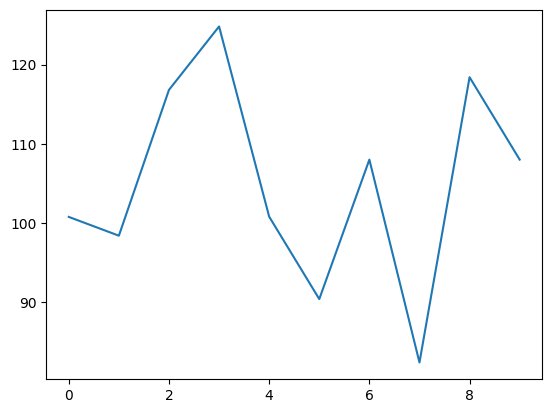

In [35]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.array_split(scores, 10)
    
averaged_epochs = list()
for epoch_list in epochs:
    averaged_epochs.append(np.mean(epoch_list))

plt.plot(averaged_epochs)
plt.show()

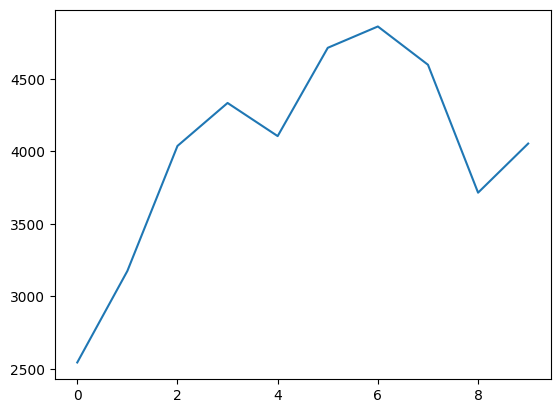

In [36]:
frames_split = np.array_split(frames, 10)
    
averaged_frames = list()
for frame_list in frames_split:
    averaged_frames.append(np.mean(frame_list))

plt.plot(averaged_frames)
plt.show()